In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, random_split
import torchvision
from torchvision import transforms
from d2l import torch as d2l
import random
import matplotlib.pyplot as plt

In [2]:
# ------------------------------
# Dataset: Overlay Pairs
# ------------------------------
transform = transforms.ToTensor()
fashion_mnist_train = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

In [3]:
class OverlayDataset(Dataset):
    def __init__(self, base_dataset, num_pairs=None):
        self.base = base_dataset
        self.num_pairs = num_pairs if num_pairs else len(base_dataset) - 1

    def __len__(self):
        return self.num_pairs

    def __getitem__(self, idx):
        imgA, _ = self.base[idx]
        imgB, _ = self.base[idx + 1]
        overlay = (imgA + imgB) / 2.0
        return overlay, imgA, imgB

In [4]:
overlay_dataset = OverlayDataset(fashion_mnist_train, num_pairs=20000)

In [5]:
# Split dataset
train_size = int(0.8 * len(overlay_dataset))
val_size   = int(0.1 * len(overlay_dataset))
test_size  = len(overlay_dataset) - train_size - val_size
train_set, val_set, test_set = random_split(
    overlay_dataset, [train_size, val_size, test_size]
)

In [6]:
# Dataloaders
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    [(overlay, imgA, imgB) for overlay, imgA, imgB in train_set],
    batch_size=batch_size, shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    [(overlay, imgA, imgB) for overlay, imgA, imgB in val_set],
    batch_size=batch_size, shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    [(overlay, imgA, imgB) for overlay, imgA, imgB in test_set],
    batch_size=batch_size, shuffle=False
)

In [7]:
# ------------------------------
# CNN Model
# ------------------------------
class ResidualSeparatorCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)

        self.res1_conv1 = nn.Conv2d(64, 128, 3, padding=1)
        self.res1_bn1 = nn.BatchNorm2d(128)
        self.res1_conv2 = nn.Conv2d(128, 64, 3, padding=1)
        self.res1_bn2 = nn.BatchNorm2d(64)

        self.res2_conv1 = nn.Conv2d(64, 128, 3, padding=1)
        self.res2_bn1   = nn.BatchNorm2d(128)
        self.res2_conv2 = nn.Conv2d(128, 64, 3, padding=1)
        self.res2_bn2   = nn.BatchNorm2d(64)


        self.branchA = nn.Sequential(
            nn.Conv2d(64, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 1, 3, padding=1),
            nn.Sigmoid()
        )

        self.branchB = nn.Sequential(
            nn.Conv2d(64, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 1, 3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))

        # Residual block 1
        res = F.relu(self.res1_bn1(self.res1_conv1(out)))
        res = self.res1_bn2(self.res1_conv2(res))
        out = F.relu(out + res)

        # Residual block 2
        res = F.relu(self.res2_bn1(self.res2_conv1(out)))
        res = self.res2_bn2(self.res2_conv2(res))  # only once!
        out = F.relu(out + res)

        outA = self.branchA(out)
        outB = self.branchB(out)
        return outA, outB

In [8]:
# Shows the results of the model on the overlay dataset
def show_overlay_results(model, dataset, index=0):
    """
    Display:
    - Overlay input
    - Original images A and B
    - Predicted images A and B
    """
    model.eval() # set model to evaluation mode
    
    # Get overlay and original images
    overlay, imgA, imgB = dataset[index]
    
    # Add batch dimension and move to device
    overlay_batch = overlay.unsqueeze(0).to(next(model.parameters()).device) # unsqueeze to add batch dimension, move to model device
    
    with torch.no_grad(): # no gradient calculation
        predA, predB = model(overlay_batch)
        predA = predA.squeeze().cpu()
        predB = predB.squeeze().cpu()
    
    # Plot
    plt.figure(figsize=(8,4))
    
    # plots the combined image
    plt.subplot(1,5,1)
    plt.imshow(overlay.squeeze(), cmap='gray')
    plt.title("Overlay")
    plt.axis('off')
    
    # plots the original first image
    plt.subplot(1,5,2)
    plt.imshow(imgA.squeeze(), cmap='gray')
    plt.title("Original A")
    plt.axis('off')
    
    # plots the original second image
    plt.subplot(1,5,3)
    plt.imshow(imgB.squeeze(), cmap='gray')
    plt.title("Original B")
    plt.axis('off')
    
    # plots the predicted first image
    plt.subplot(1,5,4)
    plt.imshow(predA, cmap='gray')
    plt.title("Predicted A")
    plt.axis('off')
    
    # plots the predicted second image
    plt.subplot(1,5,5)
    plt.imshow(predB, cmap='gray')
    plt.title("Predicted B")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [9]:
# ------------------------------
# Loss Function
# ------------------------------
def separation_loss_l1(predA, predB, imgA, imgB):
    loss1 = F.l1_loss(predA, imgA) + F.l1_loss(predB, imgB)
    loss2 = F.l1_loss(predA, imgB) + F.l1_loss(predB, imgA)
    return torch.min(loss1, loss2)

In [10]:
# ------------------------------
# Device
# ------------------------------
device = d2l.try_gpu()
model = ResidualSeparatorCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Epoch 15/15, Train Loss: 0.0081, Val Loss: 0.0083


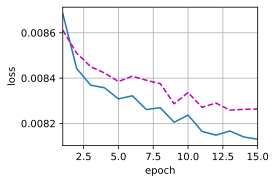

In [11]:
num_epochs = 15

animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, num_epochs])

for epoch in range(num_epochs):

    # --------------------------
    # Training
    # --------------------------

    model.train()
    metric = d2l.Accumulator(2)  # sum_loss, num_examples
    for overlay, imgA, imgB in train_loader:
        overlay, imgA, imgB = overlay.to(device), imgA.to(device), imgB.to(device)
        # Random weighted overlay
        w = torch.rand(overlay.size(0), 1, 1, 1, device=device) * 0.2 + 0.4
        overlay_rand = w * imgA + (1 - w) * imgB

        optimizer.zero_grad()
        predA, predB = model(overlay_rand)
        loss = separation_loss_l1(predA, predB, imgA, imgB)
        loss.backward()
        optimizer.step()

        metric.add(loss.item(), overlay.size(0))
    avg_train_loss = metric[0] / metric[1]

    # --------------------------
    # Validation
    # --------------------------

    model.eval()
    metric_val = d2l.Accumulator(2)
    with torch.no_grad():
        for overlay, imgA, imgB in val_loader:
            overlay, imgA, imgB = overlay.to(device), imgA.to(device), imgB.to(device)
            w = torch.rand(overlay.size(0), 1, 1, 1, device=device) * 0.2 + 0.4
            overlay_rand = w * imgA + (1 - w) * imgB

            predA, predB = model(overlay_rand)
            loss = separation_loss_l1(predA, predB, imgA, imgB)
            metric_val.add(loss.item(), overlay.size(0))

    avg_val_loss = metric_val[0] / metric_val[1]

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}")

    # --------------------------
    # Update live plot
    # --------------------------
    
    animator.add(epoch+1, (avg_train_loss, avg_val_loss))
    plt.pause(0.01)
    plt.show()

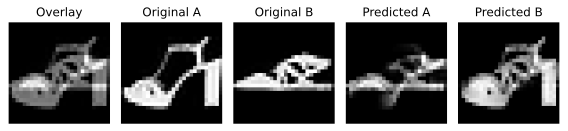

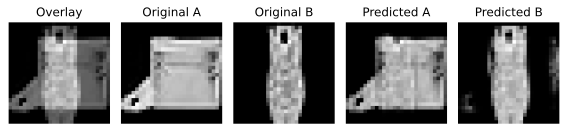

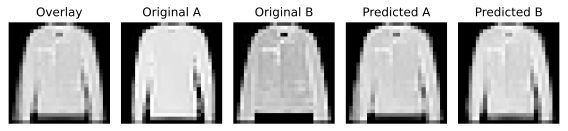

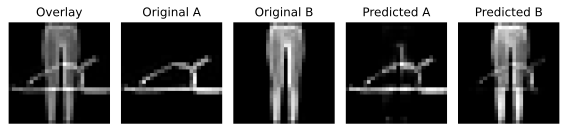

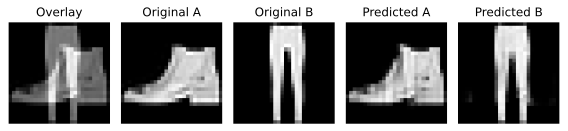

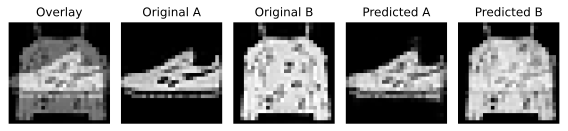

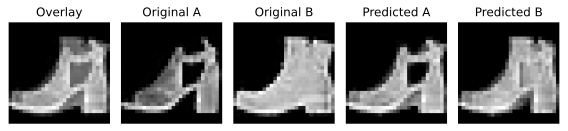

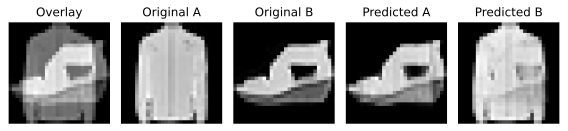

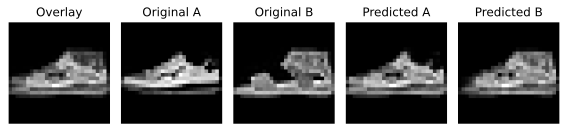

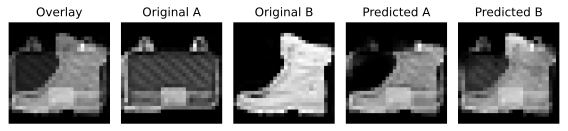

In [13]:
# Show overlay results for 10 random samples
import random
for _ in range(10):
    rand_index = random.randint(0, len(overlay_dataset) - 1)
    show_overlay_results(model, overlay_dataset, index=rand_index)

## Testing Loop

In [14]:
# --------------------------
# Testing loop
# --------------------------
model.eval()  # set model to evaluation mode
metric_test = d2l.Accumulator(2)  # sum_loss, num_examples

with torch.no_grad():
    for overlay, imgA, imgB in test_loader:
        overlay, imgA, imgB = overlay.to(device), imgA.to(device), imgB.to(device)
        # Use same blending as in training/validation
        w = torch.rand(overlay.size(0), 1, 1, 1, device=device) * 0.2 + 0.4
        overlay_rand = w * imgA + (1 - w) * imgB

        predA, predB = model(overlay_rand)
        loss = separation_loss_l1(predA, predB, imgA, imgB)
        metric_test.add(loss.item(), overlay.size(0))

avg_test_loss = metric_test[0] / metric_test[1]
print(f"Test Loss: {avg_test_loss:.4f}")

Test Loss: 0.0082


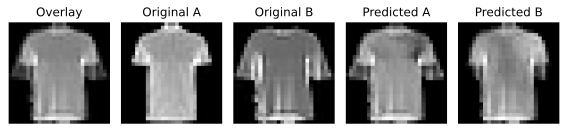

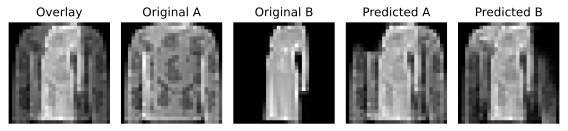

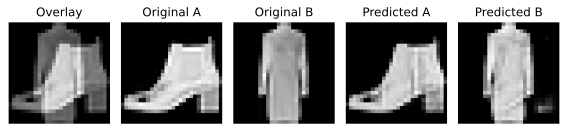

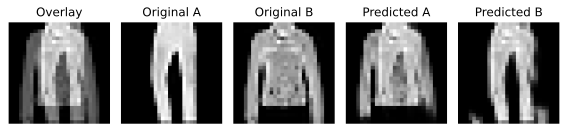

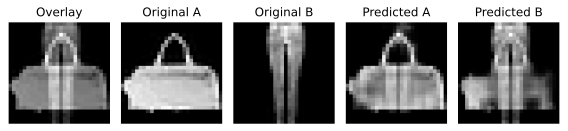

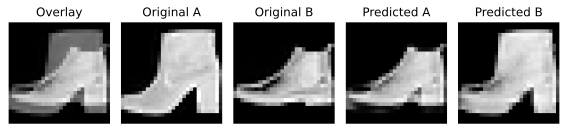

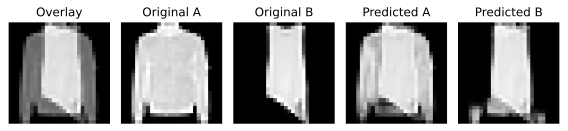

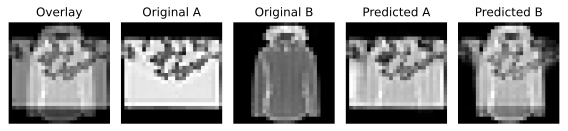

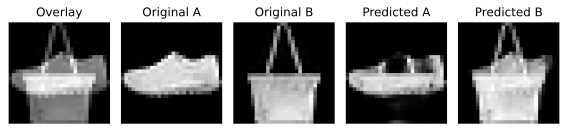

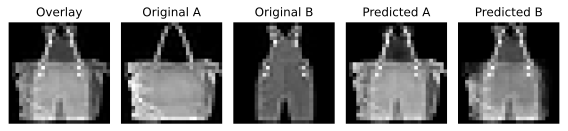

In [15]:
# Show overlay results for 10 random samples
import random
for _ in range(10):
    rand_index = random.randint(0, len(overlay_dataset) - 1)
    show_overlay_results(model, overlay_dataset, index=rand_index)